### Strand Classifier Using one Minhash Function
* A single threaded implementation of Strand as a SciKit Estimator using **only one** hashing function. 

### Test - Minhash Signature Categories
* After training, sort each category.  
* Select minhash signatures of the same length as minhash_length from each category during / after training.
* Categories are all of equal length and this simplifies the scoring formula dramatically. 

## Code to plot all grid search results 

In [94]:
# This magic just sets up matplotlib's interactive mode
%matplotlib inline
# So you have to explicitely import the module into the namespace
import matplotlib.pyplot as plt

In [95]:
# ************* WARNING - You must inspect the cv_results_ to determine which parameter is not repeately duplicated 
#                         row after row in cv_results_['params'].  This should be grid_param_1.
#                         In short, if the plot's data is not right, reverse grid_param_1 and grid_param_2.  
# https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    plt.rcParams["figure.figsize"] = (14,10)
    
    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=10)
    ax.grid(True)

## Load the RDP Dataset

In [96]:
def read_fasta_file(file_path):
    X = []
    y = []
    with open(file_path, 'r') as dat:
        for line in dat.readlines():
            #print(line)
            if line[0] == '>':
                g_start = line.find("g__")
                g_end = line.find(";", g_start)
                genus = line[g_start:g_end]
                y.append(genus)
            else:
                X.append(line)
    return X, y

In [97]:
import pandas as pd

# Read in the fasta file
X, y = read_fasta_file('D:/StrandPy/Data/RDP_All_Clean.strand')
#Remove low count genera that halt cross validation
data = {'X': X,'y':y}
df = pd.DataFrame(data)

In [98]:
#Inspect counts for each class
vcts = df.y.value_counts()
low_vcts = vcts[vcts < 20].index.values

#Remove low count genera. Any classes < the fold count will halt cross validation
df = df[~df.y.isin(low_vcts)]

# Create X and y
X = df.X.values
y = df.y.values

print('File Size: ' + str(len(X)))

File Size: 4786


In [99]:
print('Longest Sequence Chars:' + str(len(max(X, key=len))))

Longest Sequence Chars:1834


## Inspect the categories we are trying to classify

In [7]:
pd.set_option('display.max_rows', 100)
df.y.value_counts()

g__Streptomycineae                     544
g__Micrococcineae                      488
g__Corynebacterineae                   401
g__Pseudonocardineae                   192
g__Streptosporangineae                 188
g__Bacillus                            177
g__Lactobacillus                       159
g__Pseudomonas                         136
g__Clostridium_sensu_stricto           130
g__Micromonosporineae                  129
g__Paenibacillus                       126
g__Propionibacterineae                 125
g__Mycoplasma                          114
g__Shewanella                           84
g__Vibrio                               77
g__Streptococcus                        76
g__Halomonas                            64
g__Flavobacterium                       63
g__Staphylococcus                       62
g__Burkholderia                         58
g__Sphingomonas                         57
g__Desulfovibrio                        55
g__Chryseobacterium                     54
g__Actinomy

### The Baseline Strand model 
* This model version hits 99.6% during cross validation. 

In [107]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = [hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += 1
        return class_scores

In [108]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  9.0min finished


Wall time: 9min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [109]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=40, minhash_length=1000, random_state=42)

In [110]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9962390305056414

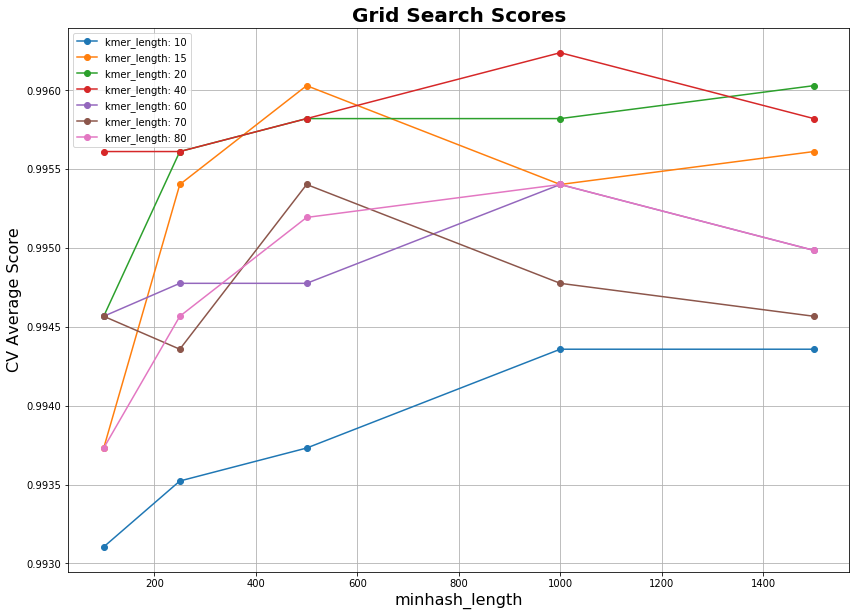

In [111]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

In [112]:
data = {'params': grid_search.cv_results_['params'], 'mean_test_score': grid_search.cv_results_['mean_test_score'] }
df = pd.DataFrame(data)
df.sort_values(['mean_test_score'],ascending=False)

,params,mean_test_score
18,"{'kmer_length': 40, 'minhash_length': 1000}",0.996239
7,"{'kmer_length': 15, 'minhash_length': 500}",0.996030
14,"{'kmer_length': 20, 'minhash_length': 1500}",0.996030
17,"{'kmer_length': 40, 'minhash_length': 500}",0.995821
13,"{'kmer_length': 20, 'minhash_length': 1000}",0.995821
12,"{'kmer_length': 20, 'minhash_length': 500}",0.995821
19,"{'kmer_length': 40, 'minhash_length': 1500}",0.995821
11,"{'kmer_length': 20, 'minhash_length': 250}",0.995612
15,"{'kmer_length': 40, 'minhash_length': 100}",0.995612
16,"{'kmer_length': 40, 'minhash_length': 250}",0.995612


### Test - Minhash Signature Categories
* After training, sort each category.  
* Select minhash signatures of the same length as minhash_length from each category during / after training.
* Categories are all of equal length and this simplifies the scoring formula dramatically. 

In [28]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        self.minhash_store_ = None
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash signatures by respective categories in minhash_store_ 
            self.add_signature_to_minhash_store(category, signature)
        
        #Traverse the minhash_store_
        for category, signature in self.minhash_store_.items():
            # Get rid of any duplicates from training on multiple sequences
            signature = list(set(signature))
            # Sort the signature in place
            signature.sort()
            # Select the minimum hash values for the category signature
            self.minhash_store_[category] = set(signature[:self.minhash_length])
        
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = list(set([hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]))
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        if category in self.minhash_store_.keys():
           self.minhash_store_[category] += minhash_signature
        else:
           self.minhash_store_[category] = minhash_signature 
        return
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Convert the minhash signature to a set
        minhash_signature = set(minhash_signature)
        class_scores = dict()
        # Get the signature for each class in the minhash_store_
        for category, category_signature in self.minhash_store_.items():
            match_count = len(minhash_signature.intersection(category_signature))
            class_scores[category] = match_count
        return class_scores

### Confirm that our code changes updated the training dictionary data correctly 

In [57]:
df = pd.DataFrame(y, columns=['y'])
len(df.y.value_counts())

64

In [53]:
strand = StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)
strand.fit(X,y)

StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)

In [56]:
len(strand.minhash_store_.keys())

64

In [55]:
for k, v in strand.minhash_store_.items():
    print(k,": ",len(v))

g__Paenibacillus :  1500
g__Propionibacterineae :  1500
g__Coriobacterineae :  1500
g__Acinetobacter :  1500
g__Corynebacterineae :  1500
g__Marinobacter :  1500
g__Micrococcineae :  1500
g__Pseudomonas :  1500
g__Micromonosporineae :  1500
g__Clostridium_sensu_stricto :  1500
g__Streptomycineae :  1500
g__Mycoplasma :  1500
g__Flavobacterium :  1500
g__Streptosporangineae :  1500
g__Desulfovibrio :  1500
g__Lysobacter :  1500
g__Helicobacter :  1500
g__Halomonas :  1500
g__Burkholderia :  1500
g__Lactobacillus :  1500
g__Prevotella :  1500
g__Bacillus :  1500
g__Spiroplasma :  1500
g__Streptococcus :  1500
g__Pseudonocardineae :  1500
g__Xenorhabdus :  1500
g__Desulfotomaculum :  1500
g__Chthonomonas/Armatimonadetes_gp3 :  1500
g__Alicyclobacillus :  1500
g__Clostridium_XlVa :  1500
g__Staphylococcus :  1500
g__Paracoccus :  1500
g__Legionella :  1500
g__Pseudoalteromonas :  1500
g__Shewanella :  1500
g__Sphingomonas :  1500
g__Treponema :  1500
g__Halorubrum :  1500
g__Brevundimonas 

### Benchmark the new model

In [41]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  7.5min finished
C:\Users\Jake\Anaconda3\envs\ML7331\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 7min 34s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [42]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)

In [43]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.908692018386962

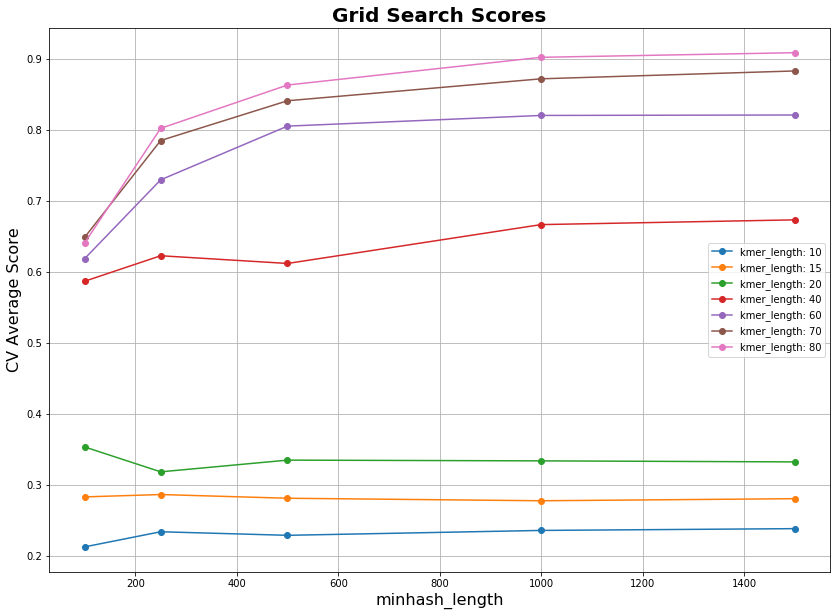

In [44]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

In [45]:
data = {'params': grid_search.cv_results_['params'], 'mean_test_score': grid_search.cv_results_['mean_test_score'] }
df = pd.DataFrame(data)
df.sort_values(['mean_test_score'],ascending=False)

,params,mean_test_score
34,"{'kmer_length': 80, 'minhash_length': 1500}",0.908692
33,"{'kmer_length': 80, 'minhash_length': 1000}",0.902215
29,"{'kmer_length': 70, 'minhash_length': 1500}",0.882992
28,"{'kmer_length': 70, 'minhash_length': 1000}",0.871918
32,"{'kmer_length': 80, 'minhash_length': 500}",0.863142
27,"{'kmer_length': 70, 'minhash_length': 500}",0.840995
24,"{'kmer_length': 60, 'minhash_length': 1500}",0.820936
23,"{'kmer_length': 60, 'minhash_length': 1000}",0.820309
22,"{'kmer_length': 60, 'minhash_length': 500}",0.805265
31,"{'kmer_length': 80, 'minhash_length': 250}",0.802131


### Test - Minhash Signature Categories

* After training, find the smallest category.  
* Select minhash signatures of the same length as the smallest category for all categories during / after training.
* Categories are all of equal length and this simplifies the scoring formula dramatically. 

In [31]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        self.minhash_store_ = None
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash signatures by respective categories in minhash_store_ 
            self.add_signature_to_minhash_store(category, signature)
            
        #Traverse the minhash_store_ removing duplicates from each category, save the smallest category size
        self.smallest_category_ = maxsize
        for category, signature in self.minhash_store_.items():
            # Get rid of any duplicates from training on multiple sequences
            signature = list(set(signature))
            self.minhash_store_[category] = signature
            self.smallest_category_ = min(self.smallest_category_, len(signature))
            
        for category, signature in self.minhash_store_.items():
            # Sort the signature in place
            signature.sort()
            # Make all category signatures the size of the smallest category
            self.minhash_store_[category] = set(signature[:self.smallest_category_])
        
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers, then sort
        kmer_hashes = list(set([hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)]))
        kmer_hashes.sort()
        #Take the first minhash_length hashes to create the signature 
        signature = kmer_hashes[:self.minhash_length]
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        if category in self.minhash_store_.keys():
            self.minhash_store_[category] += minhash_signature
        else:
            self.minhash_store_[category] = minhash_signature 
        return
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Convert the minhash signature to a set
        minhash_signature = set(minhash_signature)
        class_scores = dict()
        # Get the signature for each class in the minhash_store_
        for category, category_signature in self.minhash_store_.items():
            match_count = len(minhash_signature.intersection(category_signature))
            class_scores[category] = match_count
        return class_scores

### Confirm that our code changes updated the training dictionary data correctly 

In [32]:
df = pd.DataFrame(y, columns=['y'])
len(df.y.value_counts())

64

In [33]:
strand = StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)
strand.fit(X,y)

StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)

In [34]:
len(strand.minhash_store_.keys())

64

In [35]:
for k, v in strand.minhash_store_.items():
    print(k,": ",len(v))

g__Paenibacillus :  5526
g__Propionibacterineae :  5526
g__Coriobacterineae :  5526
g__Acinetobacter :  5526
g__Corynebacterineae :  5526
g__Marinobacter :  5526
g__Micrococcineae :  5526
g__Pseudomonas :  5526
g__Micromonosporineae :  5526
g__Clostridium_sensu_stricto :  5526
g__Streptomycineae :  5526
g__Mycoplasma :  5526
g__Flavobacterium :  5526
g__Streptosporangineae :  5526
g__Desulfovibrio :  5526
g__Lysobacter :  5526
g__Helicobacter :  5526
g__Halomonas :  5526
g__Burkholderia :  5526
g__Lactobacillus :  5526
g__Prevotella :  5526
g__Bacillus :  5526
g__Spiroplasma :  5526
g__Streptococcus :  5526
g__Pseudonocardineae :  5526
g__Xenorhabdus :  5526
g__Desulfotomaculum :  5526
g__Chthonomonas/Armatimonadetes_gp3 :  5526
g__Alicyclobacillus :  5526
g__Clostridium_XlVa :  5526
g__Staphylococcus :  5526
g__Paracoccus :  5526
g__Legionella :  5526
g__Pseudoalteromonas :  5526
g__Shewanella :  5526
g__Sphingomonas :  5526
g__Treponema :  5526
g__Halorubrum :  5526
g__Brevundimonas 

In [36]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  7.9min finished
C:\Users\Jake\Anaconda3\envs\ML7331\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 7min 59s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [37]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=80, minhash_length=1500, random_state=42)

In [38]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9270789803593815

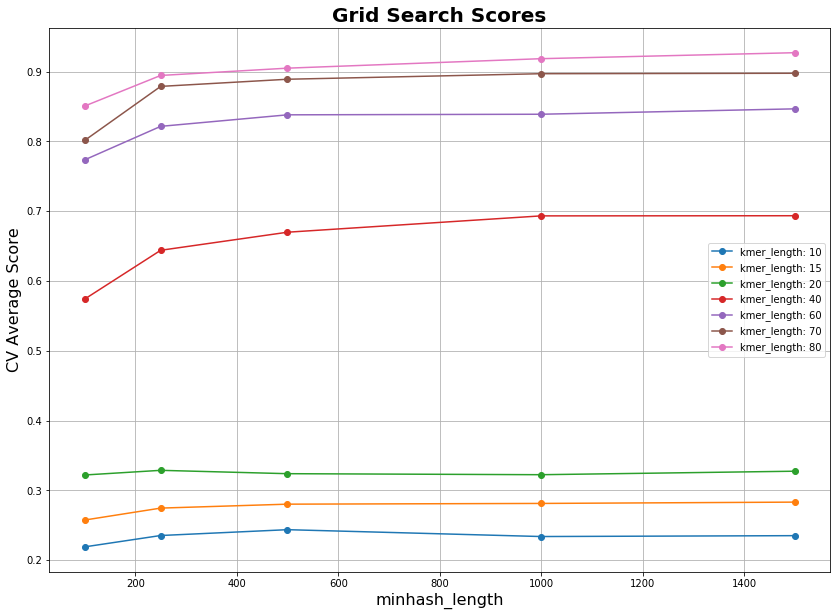

In [39]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

In [40]:
data = {'params': grid_search.cv_results_['params'], 'mean_test_score': grid_search.cv_results_['mean_test_score'] }
df = pd.DataFrame(data)
df.sort_values(['mean_test_score'],ascending=False)

,params,mean_test_score
34,"{'kmer_length': 80, 'minhash_length': 1500}",0.927079
33,"{'kmer_length': 80, 'minhash_length': 1000}",0.918512
32,"{'kmer_length': 80, 'minhash_length': 500}",0.904931
29,"{'kmer_length': 70, 'minhash_length': 1500}",0.897618
28,"{'kmer_length': 70, 'minhash_length': 1000}",0.896991
31,"{'kmer_length': 80, 'minhash_length': 250}",0.894484
27,"{'kmer_length': 70, 'minhash_length': 500}",0.889051
26,"{'kmer_length': 70, 'minhash_length': 250}",0.878813
30,"{'kmer_length': 80, 'minhash_length': 100}",0.850606
24,"{'kmer_length': 60, 'minhash_length': 1500}",0.846636


### Create minhash signatures using the most commonly occuring kmers
* This turns out to be really easy to implement using NLTK's FreqDist.most_common() function.
* I looked at kmer_length = 15 and there were no kmers that occur more than 1 time in the RDP file.
* kmer_length = 10 most of the sequences in the RDP file did not have kmers occurring > 2 or 3 times. 

In [100]:
import numpy as np
from sys import maxsize
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from nltk import FreqDist

class StrandClassifierV2(BaseEstimator, ClassifierMixin):
    """
    Parameters
    ----------
    X_ : ndarray, shape (n_samples, n_features)
         The input passed during :meth:`fit`.
    y_ : ndarray, shape (n_samples,)
         The labels passed during :meth:`fit`.
    classes_ : ndarray, shape (n_classes,)
              The classes seen at :meth:`fit`.
    kmer_length : integer, breaking the gene sequence into chunks of this length  
    minhash_length: integer, the number of minhash values to be included in the minhash signature. 
                    Longer minhash signatures approximate Jaccard Similarity more accurately and take 
                    more time to create. The total number of randomly seeded hashing functions is 
                    also controlled by the value in minhash_length.
    minhash_store_ : dict() array, shape (minhash_length), key == minhash int, value = category array int
                      Partitions unique minhash values and category associations by hash function.
    """
    def __init__(self, kmer_length=20, minhash_length=100, random_state=None):
        self.kmer_length = kmer_length
        self.random_state = random_state
        self.minhash_length = minhash_length
        
    def fit(self, X, y):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples.
        y : array-like, shape (n_samples,)
            The target values. An array of int.
        Returns
        -------
        self : object
            Returns self.
        """
        self.random_state_ = check_random_state(self.random_state)
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y, ensure_2d=False, dtype=None)
        
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        # Store the training data (X) and targets (y) used to fit the model
        self.X_ = X
        self.y_ = y
        
        # Store the minhash values and respective categories
        self.minhash_store_ = dict()
        
        # Train the model for X and y
        for sequence, category in zip(X, y):   
            # Create minhash signatures for each sequence
            signature = self.create_minhash_signature(sequence)
            # Store minhash values and respective categories to minhash_store_ partitioned by hash function 
            self.add_signature_to_minhash_store(category, signature)
            
        # Return the classifier
        return self

    def predict(self, X):
        """
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The label for each sample is the label of the closest sample
            seen during fit.
        """
        # Check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])

        # Input validation
        X = check_array(X, ensure_2d=False, dtype=None)
        
        yhats = []
        self.winning_scores_ = []
        self.scores_sums_ = []
        
        for sequence in X:
            # Create a minhash signature from the sequence X
            signature = self.create_minhash_signature(sequence)
            # Score all categories using the minhash signature  
            category_scores = self.get_category_scores(signature)
            #Get the first category with the highest score
            winning_category = max(category_scores, key=category_scores.get)
            #Add to our predictions
            yhats.append(winning_category)
            #get the the number of votes for the winning category
            self.winning_scores_.append(max(category_scores.values()))
            #get the the number of votes for the winning category
            self.scores_sums_.append(sum(category_scores.values()))
            
        
        return yhats
    
    def kmer_generator(self, sequence='', kmer_length=0):
        kmer_count = len(sequence) - (kmer_length - 1)
        for i in range(0, kmer_count):
            yield sequence[i:i + kmer_length]
    
    def create_minhash_signature(self, sequence):
        """
        Parameters
        ----------
        sequence : string, A gene sequence or other string data to be broken into kmers.
        ----------
        signature : array of int, shape (minhash_length), minimum hash value produced by each hash function
                    after hashing all kmers generated from sequence.
        """
        #Break sequence into hashed kmers and get a frequency distribution
        kmer_hashes =  FreqDist([hash(kmer) for kmer in self.kmer_generator(sequence,self.kmer_length)])
        #Take the first minhash_length most common kmers 
        signature = kmer_hashes.most_common(self.minhash_length)
        
        return signature
    
    def add_signature_to_minhash_store(self, category, minhash_signature):
        '''
        Parameters
        ----------
        category : int or string, the category value associated with this minhash_signature
        minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence. 
        '''
        # Add each minhash value and category to the minhash store
        for minhash_value in minhash_signature:
            # Do we already have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories == None:
                # No, so create a new category set for this minhash value
                self.minhash_store_[minhash_value] = {category}
            else: 
                #Yes, add the category to the minhash value's category set
                minhash_categories.add(category)
        return 
    
    '''
    Parameters
    ----------
    minhash_signature : array of int, shape (minhash_length), minimum hash value produced 
                            by each hash function after hashing all kmers generated from sequence.
    Returns
    ----------
    class_scores : dict, shape (minhash_length), key = category, value = category score int
                   The count of categories associated with each hash function's minhash value. 
    '''
    def get_category_scores(self, minhash_signature):
        # Create a dictionary of category / class scores
        class_scores = dict.fromkeys(self.classes_ , 0)
        # lookup minhash values in minhash stores 
        for minhash_value in minhash_signature:
            # Do we have categories for this minhash value? 
            minhash_categories = self.minhash_store_.get(minhash_value, None)
            if minhash_categories != None:
                # Yes, add 1 for each category in the set  
                for category in minhash_categories:
                    class_scores[category] += 1
        return class_scores

In [101]:
# Non nltk solution for getting kmer frequencies sorted desc
#    kmer_hashes = [hash(kmer) for kmer in kmer_generator(x)]
#    x = Counter(kmer_hashes)
#    y = [[k, v] for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)]

In [102]:
%%time
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# create cross validation iterator
cv = StratifiedKFold(n_splits=10, random_state=42)

strand = StrandClassifierV2(random_state=42)

parameters = { 'kmer_length':[10,15,20,40,60,70,80]
              ,'minhash_length': [100,250,500,1000,1500]
             }

grid_search = GridSearchCV(estimator=strand
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity in output messages
                   , param_grid=parameters
                   , cv=cv
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
grid_search.fit(X, y)

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed: 18.1min finished
C:\Users\Jake\Anaconda3\envs\ML7331\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Wall time: 18min 20s


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=StrandClassifierV2(kmer_length=20, minhash_length=100,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'kmer_length': [10, 15, 20, 40, 60, 70, 80],
                         'minhash_length': [100, 250, 500, 1000, 1500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

In [103]:
grid_search.best_estimator_

StrandClassifierV2(kmer_length=20, minhash_length=1500, random_state=42)

In [104]:
print('Highest CV Mean Accuracy')
max(grid_search.cv_results_['mean_test_score'])

Highest CV Mean Accuracy


0.9960300877559549

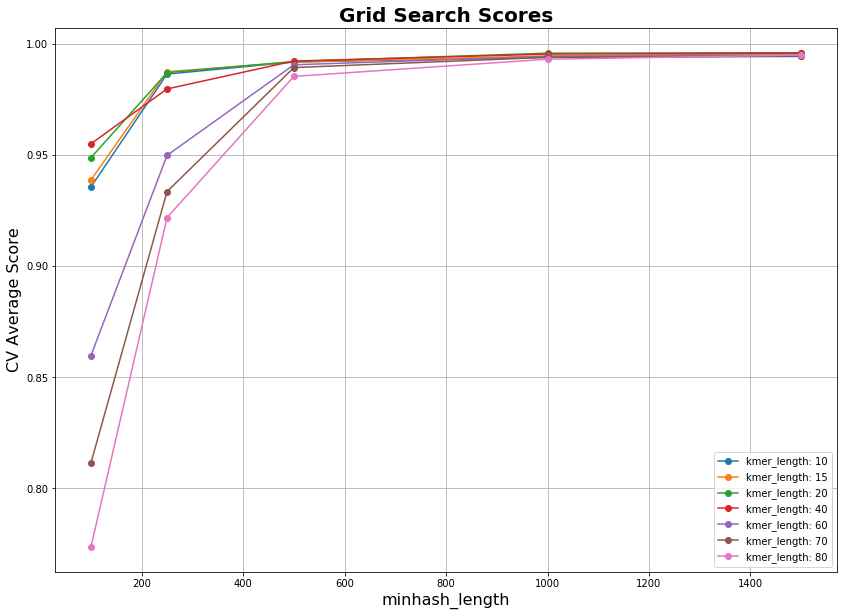

In [105]:
plot_grid_search(grid_search.cv_results_, parameters['minhash_length'], 
                 parameters['kmer_length'], 'minhash_length','kmer_length')

In [106]:
data = {'params': grid_search.cv_results_['params'], 'mean_test_score': grid_search.cv_results_['mean_test_score'] }
df = pd.DataFrame(data)
df.sort_values(['mean_test_score'],ascending=False)

,params,mean_test_score
14,"{'kmer_length': 20, 'minhash_length': 1500}",0.996030
19,"{'kmer_length': 40, 'minhash_length': 1500}",0.995821
13,"{'kmer_length': 20, 'minhash_length': 1000}",0.995821
9,"{'kmer_length': 15, 'minhash_length': 1500}",0.995612
18,"{'kmer_length': 40, 'minhash_length': 1000}",0.995403
34,"{'kmer_length': 80, 'minhash_length': 1500}",0.994985
24,"{'kmer_length': 60, 'minhash_length': 1500}",0.994985
29,"{'kmer_length': 70, 'minhash_length': 1500}",0.994567
8,"{'kmer_length': 15, 'minhash_length': 1000}",0.994567
4,"{'kmer_length': 10, 'minhash_length': 1500}",0.994359
